# import required libraries

In [1]:
import cv2
import pdf2image
import pytesseract
import matplotlib.pyplot as plt
import re

# Read data

In [2]:
PATH = "/home/nullgravity/Projects/Aventus ML Machine test.pdf"

In [157]:
# the given data in PDFs, Converting to Array/Image
def convert_pdf_to_image(document):
    images = []
    images.extend(list(map(lambda image: cv2.cvtColor(np.asarray(image), code=cv2.COLOR_RGB2BGR),pdf2image.convert_from_path(document), )))
    return images

In [4]:
images = convert_pdf_to_image(PATH)

In [5]:
print("No of pages: ",len(images))

No of pages:  2


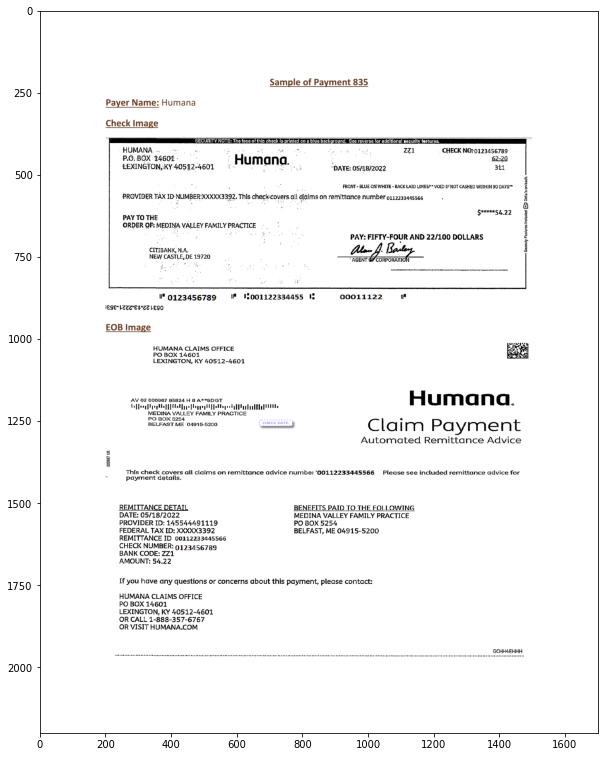

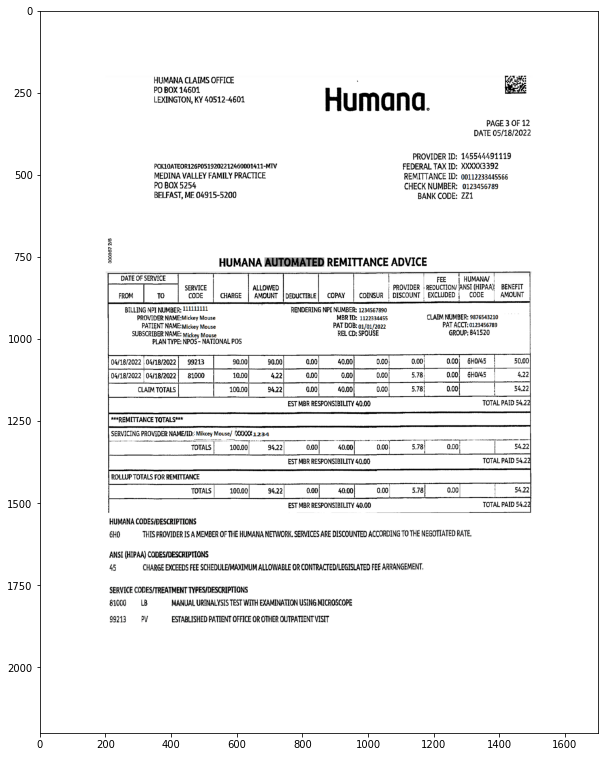

In [6]:
for i in range(len(images)):
    plt.figure(figsize=(10,15))
    plt.imshow(images[i])

#### from the above images, there is three part 
##### 1. Cheque image
##### 2.EOB image
##### 3. Page with table
Here we can apply another model for classification. Using computer vision we can crop these areas from the invoice. Most of the invoices have tables. for extracting table i'm using opencv. But here the actual requirement is not clear. So im directly moving to extract the information by using the NLP without classification model applied. 

Here i'm using the NER method.


In [7]:
# Model training

In [27]:
# Some basic preprocessing for better ocr performance
def preprocess_image(images):
    #images = cv2.resize(images, None, fx=5, fy=5, interpolation=cv2.INTER_AREA)
    ret, img = cv2.threshold(images, 0, 255,cv2.THRESH_BINARY,cv2.THRESH_OTSU)
    dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15) 
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(dst,kernel,iterations = 1)
    return erosion

In [49]:
img_1  = preprocess_image(images[0])
img_2 = preprocess_image(images[1])

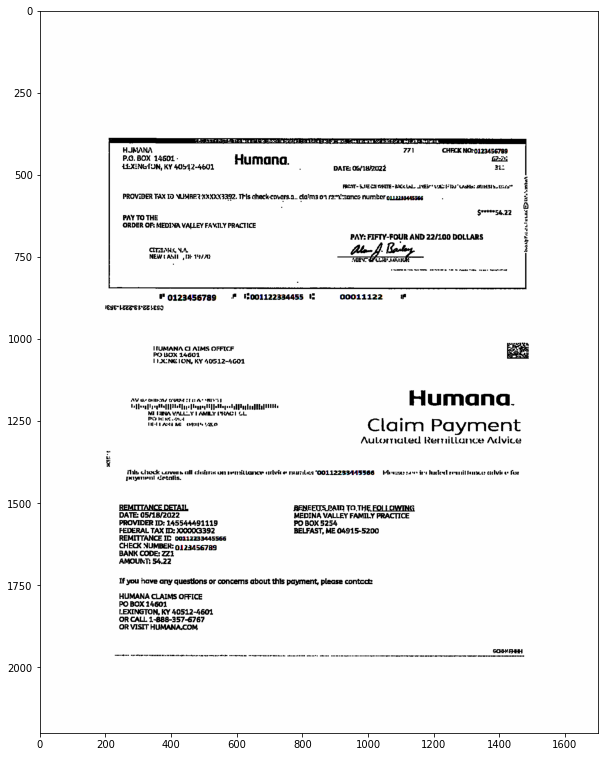

In [50]:
plt.figure(figsize=(10,15))
plt.imshow(img_1)

In [51]:
# Convert images to text
txt1 = pytesseract.image_to_string(img_2,config="--psm 4 oem")
txt1 = re.sub("\n"," ",txt1)
txt2 = pytesseract.image_to_string(img_2,config="--psm 4 oem")
txt2 = re.sub("\n"," ",txt2)

In [52]:
# join both text
txt = txt2+txt1

In [53]:
# save to txt file for NER annotation
text_file = open("sample.txt", "wt")
n = text_file.write(txt)
text_file.close()

Most common nlp libraries are nltk and spaCy. Here I'm using the spacy instead of nltk. Spacy is advanced version of the latest nltk. Both have the same tools. spaCY is little bit easier than nltk

In [73]:
import json
 
with open('data.json', 'r') as f:
    data = json.load(f)
    
#print(data['examples'][0])

In [74]:
data

[{'text': 'HUMANA CLAIMS OFFICE PO BOX 14601  LEXINGTON, KY 40512-4601 H U Mm Gg Nn Q  ar  PAGE 3 OF 12 DATE 05/18/2022  PROVIDER ID: 145544491119  PCKLOATEOR126P05192072 12450001411-MiV FEDERAL TAX IB: XXXXX3392 MEDINA VALLEY FAMILY PRACTICE REMI: TANCE [D: 00112233445566 PO BOX 5254 CHECK NUMBER: 0123456789 BELFAST, ME 04915-5200 BANK CODE: 721 & = HUMANA AUTOMATED REMITTANCE ADVICE DATE OF SERVICE t FEE | HUMANA/ SERVICE | ALLOWES PROVIDER REDUCTION/ ANSI (HIPAA = BENEFET | TO | CODE | CHARGE AMOUNT | DEDUCTIBLE} COPAY COINSUR DISCOUNT ; EXCLUDED , CODE AMOUNT BILLING N27 NUMBER: 221211112 RENDERING NPI NUMBER: 1234567890 PROVIDER MAME:Mickey Mouse MRR Te 1127334455 CLAIM NUMBER: 9876543210 JATIENT NAME:Mickey Mouse PAT DOB: 01/01/2022 PAT ACCT: 0123456789 SUBSCRIBER NAME: Vickey Mouse REL CD: SPOUSE GROUP: 651520 |  PLAN TYPE: NPOS - NATIONAL POS |  04/18/2022 04/18/2022 | 99213 | $0.00] 90.00 ooo] 40.00 0.00- 0,00: 0.00} 6HOS | = 5000  04/18/2022 04/18/2022] 81000 10,00| 4.22| 6.0

# Train Custom Model

In [78]:


!pip install -U spacy -q



In [79]:
!python3 -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.4.0                         
Location         /home/nullgravity/.local/lib/python3.10/site-packages/spacy
Platform         Linux-5.15.0-41-generic-x86_64-with-glibc2.35
Python version   3.10.4                        
Pipelines        en_core_web_sm (3.4.0)        



In [80]:


import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
db = DocBin() # create a DocBin object



In [83]:


import json
f = open('annotations.json')
TRAIN_DATA = json.load(f)



In [84]:
for text, annot in tqdm(TRAIN_DATA['annotations']): 
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in annot["entities"]:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents 
    db.add(doc)

db.to_disk("./training_data.spacy") # save the docbin object

100%|██████████| 2/2 [00:00<00:00, 73.79it/s]


In [86]:
!python3 -m spacy init config config.cfg --lang en --pipeline ner --optimize efficiency

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [87]:
!python3 -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-07-24 17:37:07,790] [INFO] Set up nlp object from config
[2022-07-24 17:37:07,799] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-07-24 17:37:07,803] [INFO] Created vocabulary
[2022-07-24 17:37:07,804] [INFO] Finished initializing nlp object
[2022-07-24 17:37:08,050] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    218.29    0.00    0.00    0.00    0.00
100     200       4970.68   5885.43   91.67  100.00   84.62    0.92
200     400         16.32    447.55   92.31   92.31   92.31    0.92
300     600         13.85    441.94   92.31   92

In [88]:


nlp_ner = spacy.load("model-best")



In [161]:
doc = nlp_ner(txt)

In [162]:
spacy.displacy.render(doc, style="ent", jupyter=True)

In [163]:
dic={}
for ent in doc.ents:
    dic[ent.label_]=ent.text

In [164]:
dic


{'ADDRESS': 'HUMANA CLAIMS OFFICE 5 fee PO BOX 14601  LEXINGTON, KY 40512-4601',
 'DATE': '05/18/2022',
 'PROVIDERID': '145544492119',
 'TAXID': 'XXXXX3392',
 'REMITTANCEID': '0011223344566',
 'CHECKNO': '0123456789',
 'BANKCODE': '2Z1',
 'NAME': 'HUMANA'}

In [166]:
import numpy as np
import pandas as pd
import csv
try:
    from PIL import Image
except ImportError:
    import Image


In [167]:
#read your file
file=r'bb.png'
img = cv2.imread(file,0)
img.shape#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)#inverting the image 
img_bin = 255-img_bin


In [168]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

In [169]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)


In [170]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)


In [173]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)#Plotting the generated image


In [174]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [177]:
def sort_contours(cnts, method="left-to-right"):    # initialize the reverse flag and sort index
    reverse = False
    i = 0    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)
# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

In [178]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]#Get mean of heights
mean = np.mean(heights)

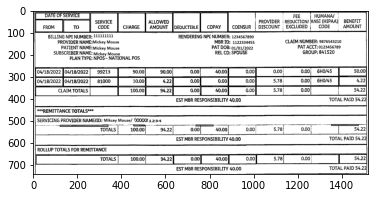

In [183]:
#Create list box to store all boxes in  
box = []# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)    
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
        plotting = plt.imshow(image,cmap='gray')

In [187]:
row = []
column = []
j = 0
for i in range(len(box)):
    if (i == 0):
        column.append(box[i])
        previous = box[i]
    else:
        if (box[i][1] <= previous[1] + mean / 2):
            column.append(box[i])
            previous = box[i]
            if (i == len(box) - 1):
                row.append(column)
        else:
            row.append(column)
            # column=[]
            previous = box[i]
            column.append(box[i])


In [188]:
#calculating maximum number of cellscountcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [190]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [192]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [199]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=""
        if(len(finalboxes[i][j])==0):
            outer.append(' ')        
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                    out = re.sub("\n"," ",out)
                inner = inner +" "+ out            
            outer.append(inner)

In [203]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")#Converting it in a excel-file
data.to_excel("output.xlsx")

                                                  0  1  2                 3   \
0   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   
1   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   
2   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   
3   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   
4   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   
5   __ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...         CLAIM TOTALS\n   

                                                  4  5  6                  7   \
0    04/18/2022| 99213\n 04/18/2022 | 81000 |\n...         SERVICE\nCODE\n   
1    04/18/2022| 99213\n 04/18/2022 | 81000 |\n...         SERVICE\nCODE\n   
2    04/18/2022| 99213\n 04/18/2022 | 81000 |\n...         SERVICE\nCODE\n   
3    04/18/2022| 99213\n 04/18/2022 | 81000 |\n...         SERVICE\nCODE\n   
4    04/18/2022| 99213\n 04/18/2

In [198]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,
1,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,
2,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,
3,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,
4,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,
5,__ DATE OF SERVICE\n FROM\n 04/18/2022.\n ...,,,CLAIM TOTALS\n,04/18/2022| 99213\n 04/18/2022 | 81000 |\n...,,,SERVICE\nCODE\n,,,...,FEE | HUMANA/ |\n| PROVIDER | REDUCTION/ JANS...,0.00; 0.00) GHO/4S\n \n\n6HO/45\n 5.78} 0....,,,,,50.00\n 4.22\n \n 54.22\n,,,


This will be the strategy used for projects of this nature.More data must be trained in order to improve the NER. Here i'm used only one data annotated.
The table is manually cropped and used with opencv.we can use block detection for crop the table in practical. Table also has not been preprocessed.The table is unstructured because of this. 

Please get in touch with me for further details. 